In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn import linear_model

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [3]:
def transform_features(df):
    # Drop coloumns with over 5% missing values
    threshhold = len(df) * .05
    df = df.dropna(axis=1, thresh=threshhold)
    
    # Replace missing values in remaining number columns
    num_cols = df.select_dtypes(include=['float','int']).columns.tolist()
    for col in num_cols:
        popular = df[col].value_counts().idxmax()
        df[col] = df[col].fillna(popular)

    # Drop text columns with missing values
    text_cols = df.select_dtypes(include=['object']).columns.tolist()
    for col in text_cols:
        if df[col].isnull().sum() > 0:
            df = df.drop(col, axis =1)

    # Create new features
    df['Years Before Sale'] = df['Yr Sold'] - df['Year Built']
    df['Years Since Remod'] = df['Yr Sold'] - df['Year Remod/Add']
    
    # Drop rows with negative values for both of these new features
    df = df.drop([1702, 2180, 2181], axis=0)

    # No longer need original year columns
    df = df.drop(["Year Built", "Year Remod/Add"], axis = 1)

    # Drop columns that aren't useful for ML## Drop c 
    df = df.drop(["PID", "Order"], axis=1)

    # Drop columns that leak info about the final sale
    df = df.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)

    return df

In [4]:
def select_features(df):
    target = 'SalePrice'
    
    # Find columns that correlated with SalePrice
    corr_df = df.corr()
    sorted_corrs = corr_df[target].abs().sort_values(ascending=True)
    strong_corrs = sorted_corrs[sorted_corrs > 0.4]
    features = strong_corrs.index.tolist()
    df_features = df[features]

    # Categorical columns
    nominal = ["MS SubClass", "MS Zoning", "Street", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Foundation", "Heating", "Central Air"]

    # drop categorical cols with over 10 unique values
    df_nominal = df[nominal]
    uniqueness_counts = df_nominal.nunique()
    drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
    df_nominal = df_nominal.drop(drop_nonuniq_cols, axis=1)
    
    text_cols = df_nominal.select_dtypes(include=['object']).columns
    for col in text_cols:
        df_nominal[col] = df_nominal[col].astype('category')

    ## Create dummy columns and add back to the dataframe!
    df_nominal = pd.get_dummies(df_nominal.select_dtypes(include=['category']))
    
    features_df = pd.concat([df_features, df_nominal], axis=1)

    return features_df

In [7]:
def train_and_test(df, k):
    features = df.columns.drop("SalePrice")
    lr = linear_model.LinearRegression()
    
    if k == 0:
        train = df[:1460]
        test = df[1460:]
        
        lr.fit(train[features], train["SalePrice"])

        predictions = lr.predict(test[features])
        mse = mean_squared_error(test["SalePrice"], predictions)
        rmse = np.sqrt(mse)
    
        return rmse
    
    if k == 1:
        shuffled_df = df.sample(frac=1, )
        train = df[:1460]
        test = df[1460:]
        
        lr.fit(train[features], train["SalePrice"])
        predictions_1 = lr.predict(test[features])
        
        mse_1 = mean_squared_error(test["SalePrice"], predictions_1)
        rmse_1 = np.sqrt(mse_1)
        
        lr.fit(test[features], test["SalePrice"])
        predictions_2 = lr.predict(train[features])
        
        mse_2 = mean_squared_error(train["SalePrice"], predictions_2)
        rmse_2 = np.sqrt(mse_2)
        
        avg_rmse = np.mean([rmse_1, rmse_2])
        print(rmse_1)
        print(rmse_2)
        return avg_rmse

    else:
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values = []
        for train_index, test_index, in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr.fit(train[features], train["SalePrice"])
            predictions = lr.predict(test[features])
            mse = mean_squared_error(test["SalePrice"], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
        print(rmse_values)
        avg_rmse = np.mean(rmse_values)
        return avg_rmse
        
        

In [8]:
df2 = transform_features(df)
df2 = select_features(df2)
print(train_and_test(df2, 1))

35032.896997149925
29605.325204636993
32319.11110089346


## Feature Exploration

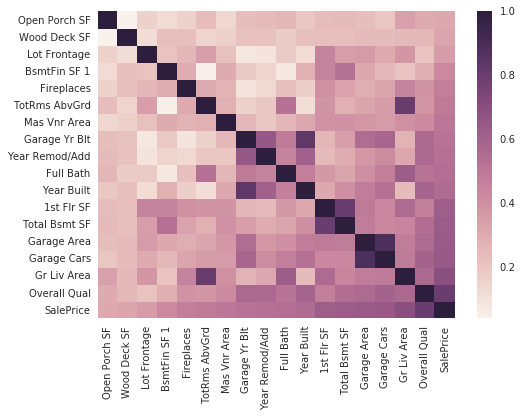

In [10]:
# Numerical Features
corr_df = df.select_dtypes(include=['int','float'])
corr_df = df.corr()
sorted_corrs = corr_df['SalePrice'].abs().sort_values(ascending=True)

strong_corrs = sorted_corrs[sorted_corrs > 0.3]
corrmat = df[strong_corrs.index].corr()
sns.heatmap(corrmat)
plt.show()

In [11]:
# Looks like we'll want to remove
drop_correlated = ['Garage Cars', 'Total Bsmt SF', 'TotRms AbvGrd', 'Garage Yr Blt', 'SalePrice']
strong_corrs = strong_corrs.drop(drop_correlated)
print(strong_corrs)


Open Porch SF     0.312951
Wood Deck SF      0.327143
Lot Frontage      0.357318
BsmtFin SF 1      0.432914
Fireplaces        0.474558
Mas Vnr Area      0.508285
Year Remod/Add    0.532974
Full Bath         0.545604
Year Built        0.558426
1st Flr SF        0.621676
Garage Area       0.640401
Gr Liv Area       0.706780
Overall Qual      0.799262
Name: SalePrice, dtype: float64


In [12]:
features = strong_corrs.index.tolist()
print(features)

['Open Porch SF', 'Wood Deck SF', 'Lot Frontage', 'BsmtFin SF 1', 'Fireplaces', 'Mas Vnr Area', 'Year Remod/Add', 'Full Bath', 'Year Built', '1st Flr SF', 'Garage Area', 'Gr Liv Area', 'Overall Qual']


In [23]:
df_num = df[features]

In [26]:
df_num.shape

(2930, 13)

In [16]:
# Cat Features
nominal = ["MS SubClass", "MS Zoning", "Street", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Foundation", "Heating", "Central Air"]


In [17]:
df_nominal = df[nominal]
df_nominal.head()

,MS SubClass,MS Zoning,Street,Land Contour,Lot Config,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Foundation,Heating,Central Air
0,20,RL,Pave,Lvl,Corner,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,BrkFace,Plywood,CBlock,GasA,Y
1,20,RH,Pave,Lvl,Inside,NAmes,Feedr,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,CBlock,GasA,Y
2,20,RL,Pave,Lvl,Corner,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,Wd Sdng,Wd Sdng,CBlock,GasA,Y
3,20,RL,Pave,Lvl,Corner,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,BrkFace,BrkFace,CBlock,GasA,Y
4,60,RL,Pave,Lvl,Inside,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,PConc,GasA,Y


In [20]:
uniqueness_counts = df_nominal.nunique()
uniqueness_counts
drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
df_nominal = df_nominal.drop(drop_nonuniq_cols, axis=1)



In [21]:
text_cols = df_nominal.select_dtypes(include=['object']).columns
for col in text_cols:
    df_nominal[col] = df_nominal[col].astype('category')

## Create dummy columns and add back to the dataframe!
df_nominal = pd.get_dummies(df_nominal.select_dtypes(include=['category']))

In [ ]:
## Next Steps